# BootCamp 2019 - Week 5

## Newton and Quasi Newton Method

Author: Martina Fraschini

In [1]:
# import packages
import numpy as np
from scipy import linalg as la
from scipy import optimize as opt
import time
from matplotlib import pyplot as plt

### Problem 1

In [2]:
# define a function that implements the Newton method
def myNewton(Df, D2f, x0, maxiter, tol):
    convergence = False
    x_old = np.copy(x0)
    Dfx = Df(x_old)
    for k in range(maxiter):
        z = la.solve(D2f(x_old), Dfx)
        x_new = x_old - z
        Dfx = Df(x_new)
        err = la.norm(Dfx, np.inf)
        if err < tol:
            convergence = True
            return x_new, convergence, k
        else:
            x_old = np.copy(x_new)
    
    return x_new, convergence, k

f = opt.rosen
df = opt.rosen_der
d2f = opt.rosen_hess
x0 = np.array([-2,2])
x_star, conv, nit = myNewton(df, d2f, x0, 500, 1e-08)
if conv:
    print("The algorithm converged in {} iterations.".format(nit))
    print("The minimizer is ", x_star)
    print("The value of the funciton is ", f(x_star))
else:
    print("The algorithm didn't converge.")

The algorithm converged in 4 iterations.
The minimizer is  [1. 1.]
The value of the funciton is  1.8096151744628943e-19


### Problem 2

In [3]:
# define a function that implements the BFGS method
def myBFGS(Df, x0, maxiter, tol):
    invA_old = np.eye(len(x0))
    convergence = False
    x_old = np.copy(x0)
    Dfx_old = Df(x_old)
    for k in range(maxiter):
        x_new = x_old - invA_old @ Dfx_old.T
        
        Dfx_new = Df(x_new)
        s = x_new - x_old
        y = Dfx_new.T - Dfx_old.T
        sy2 = (s.T@y)**2
        if sy2 == 0:
            return x_new, convergence, k
        term1 = (s.T@y + y.T@invA_old@y) * np.outer(s,s) / sy2
        term2 = (invA_old@np.outer(y,s) + np.outer(s,y)@invA_old) / (s.T@y)
        invA_new = invA_old + term1 - term2
        
        err = la.norm(Dfx_new, np.inf)
        if err < tol:
            convergence = True
            return x_new, convergence, k
        else:
            x_old = np.copy(x_new)
            Dfx_old = np.copy(Dfx_new)
            invA_old = np.copy(invA_new)
    
    return x_new, convergence, k

f = opt.rosen
df = opt.rosen_der
d2f = opt.rosen_hess
x0 = np.array([-2,2])
x_star, conv, nit = myBFGS(df, x0, 500, 1e-08)
if conv:
    print("The algorithm converged in {} iterations.".format(nit))
    print("The minimizer is ", x_star)
    print("The value of the funciton is ", f(x_star))
else:
    print("The algorithm didn't converge.")

The algorithm converged in 145 iterations.
The minimizer is  [1. 1.]
The value of the funciton is  4.808866269541495e-20


### Problem 3

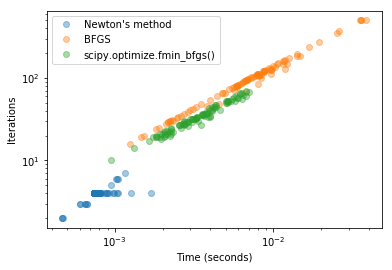

In [4]:
def testmethods(N):
    time_myNewt = np.empty(N)
    time_myBFGS = np.empty(N)
    time_pyBFGS = np.empty(N)
    nit_myNewt = np.empty(N)
    nit_myBFGS = np.empty(N)
    nit_pyBFGS = np.empty(N)
    
    f = opt.rosen
    df = opt.rosen_der
    d2f = opt.rosen_hess
    
    for n in range(N):
        x0 = np.array([np.random.random(), np.random.random()])
        x0 = 6 * x0 - 3
        
        # My Netwton method
        start = time.time()
        _, _, nit_myNewt[n] = myNewton(df, d2f, x0, 500, 1e-08)
        time_myNewt[n] = time.time() - start
        
        # My BFGS method
        start = time.time()
        _, _, nit_myBFGS[n] = myBFGS(df, x0, 500, 1e-08)
        time_myBFGS[n] = time.time() - start
        
        # Python minimizer
        start = time.time()
        output = opt.fmin_bfgs(f=f, x0=x0, fprime=df, maxiter=500, disp=False, retall=True)
        nit_pyBFGS[n] = len(output[1])
        time_pyBFGS[n] = time.time() - start
    
    plt.loglog(time_myNewt, nit_myNewt, 'o', alpha=0.4, label="Newton's method")
    plt.loglog(time_myBFGS, nit_myBFGS, 'o', alpha=0.4, label="BFGS")
    plt.loglog(time_pyBFGS, nit_pyBFGS, 'o', alpha=0.4, label="scipy.optimize.fmin_bfgs()")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Iterations")
    plt.legend()
    plt.show()
    
testmethods(100)

### Problem 4

In [5]:
def myGaussNewton(phi, r, J, x0, maxiter, tol):
    convergence = False
    x_old = np.copy(x0)
    Jx = J(x_old)
    for k in range(maxiter):
        z = la.solve(Jx.T@Jx, Jx.T@r(x_old))
        x_new = x_old - z
        Jx = J(x_new)
        err = la.norm(x_new-x_old, np.inf)
        if err < tol:
            convergence = True
            return x_new, convergence, k
        else:
            x_old = np.copy(x_new)
            
    return x_new, convergence, k

T = np.arange(10)
y = 3*np.sin(0.5*T)+ 0.5*np.random.randn(10)
model = lambda x, t: x[0]*np.sin(x[1]*t)
residual = lambda x: model(x, T) - y
jac = lambda x: np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))
x0 = np.array([2.5,.6])

x_star, conv, nit = myGaussNewton(model, residual, jac, x0, maxiter=10, tol=1e-8)

if conv:
    print("The algorithm converged in {} iterations.".format(nit))
    print("The minimizer is ", x_star)
else:
    print("The algorithm didn't converge.")

The algorithm converged in 6 iterations.
The minimizer is  [3.33061952 0.52240662]


In [6]:
minx = opt.leastsq(func=residual, x0=np.array([2.5,.6]), Dfun=jac)
print(minx[0])

[3.33061948 0.52240663]


### Problem 5

The algorithm converged in 6 iterations.
The minimizer is  [1.67729595 0.18474177 9.11885064]


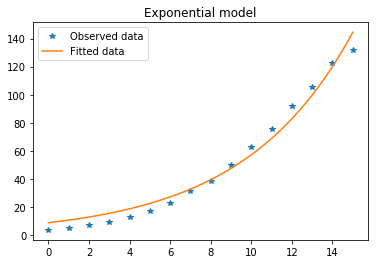

In [7]:
T, y = np.load("population.npy").T

# Exponential model
model = lambda x, t: x[0]*np.exp(x[1]*(t+x[2]))
residual = lambda x: model(x, T) - y
jac = lambda x: np.column_stack((np.exp(x[1]*(T+x[2])), x[0]*(T+x[2])*np.exp(x[1]*(T+x[2])), x[0]*x[1]*np.exp(x[1]*(T+x[2]))))
x0 = np.array([1.5,.4,2.5])

minx = opt.leastsq(func=residual, x0=x0, Dfun=jac)
x_star = minx[0]

if conv:
    print("The algorithm converged in {} iterations.".format(nit))
    print("The minimizer is ", x_star)
else:
    print("The algorithm didn't converge.")

dom = np.linspace(0, 15, 200)
plt.plot(T, y, '*', label="Observed data")
plt.plot(dom, model(x_star, dom), label="Fitted data")
plt.title("Exponential model")
plt.legend()
plt.show()


The algorithm converged in 6 iterations.
The minimizer is  [170.71506221   0.31723848 -11.50539991]


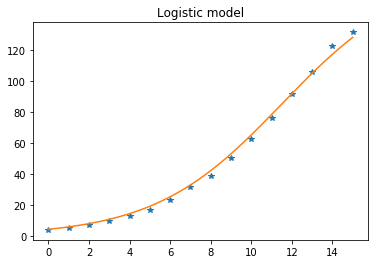

In [8]:
# Logistic model
model = lambda x, t: x[0]/(1+np.exp(-x[1]*(t+x[2])))
residual = lambda x: model(x, T) - y
jac = lambda x: np.column_stack((1/(1+np.exp(-x[1]*(T+x[2]))), - x[0]*(-T-x[2])*np.exp(x[1]*(T+x[2]))/(1+np.exp(-x[1]*(T+x[2])))**2, x[0]*x[1]*np.exp(x[1]*(T+x[2]))/(1+np.exp(-x[1]*(T+x[2])))**2))
x0 = np.array([150,.4,-15])

minx = opt.leastsq(func=residual, x0=x0, Dfun=jac)
x_star = minx[0]

if conv:
    print("The algorithm converged in {} iterations.".format(nit))
    print("The minimizer is ", x_star)
else:
    print("The algorithm didn't converge.")

dom = np.linspace(0, 15, 200)
plt.plot(T, y, '*', label="Observed data")
plt.plot(dom, model(x_star, dom), label="Fitted data")
plt.title("Logistic model")
plt.show()